# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    
    def encode(self, word):
        # Returns the 1D embedding of a given word    
        id_word = self.word2id[word]
        encoding = self.embeddings[id_word, :]
        return encoding
        
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        
        # Check if the input words are strings (and we should retrieve their embeddings)
        if isinstance(word1, str):    
            word1 = self.encode(word1)
        if isinstance(word2, str):
            word2 = self.encode(word2)
        
        dot_product = np.dot(word1, word2)
        norm1 = np.linalg.norm(word1)
        norm2 = np.linalg.norm(word2)
        
        cosine_similarity = dot_product / (norm1 * norm2)
        return cosine_similarity        
        
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 

        scores = []
        word_id = self.word2id[word]
        
        for word_2 in self.words:
            word_2_id = self.word2id[word_2]
            scores.append(self.score(word, word_2))
        
        sorted_indices = np.argsort(scores)
        most_similar_words = [self.words[index] for index in sorted_indices[-(k+1):-1]] # we do not take the same word
        
        return (most_similar_words[::-1]) # return in reverse order (from the most relevant word to the least relevant)
        

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))
    

Loaded 50000 pretrained word vectors
cat tree 0.2644975466165475
cat dog 0.7078641298542562
cat pet 0.6753313359976381
Paris France 0.6892958925806542
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348005
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [4]:
from nltk.corpus import stopwords

class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
        
        
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        
        no_sentences = len(sentences) 
        idf = {new_word: 0.0 for new_word in self.word2vec.words} #take all the words from the vocab and associate them with 0 appearances
        
        for sentence in sentences:
            words_sentence = set(sentence.split()) #to not have duplicates (because we count the number of
            #documents a word appears, so if it appears twice in the same document, we want to count it only once)
        
            for word_sentence in words_sentence:
                if word_sentence in self.word2vec.words: #check if the word is in the vocabulary
                    idf[word_sentence] = idf[word_sentence] + 1.0
                
        for word in idf.keys():
            idf[word] = np.log((no_sentences * 1.0) / (idf[word] + 1e-6)) #to avoid dividing by 0
        
        return idf

    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding

        words_sentence = np.char.split(sentence).item()        
        
        sum_embeddings = np.zeros((word2vec.embeddings.shape[1]))
        nr_words_not_dict = 0
        if idf is None:
            # mean of word vectors
            #The words that are not in the dictionary are ignored
            for index_word in range(len(words_sentence)):
                word_sentence = words_sentence[index_word]
                if word_sentence in word2vec.word2id:          
                    sum_embeddings += self.word2vec.encode(word_sentence)
                else:
                    nr_words_not_dict += 1
            
        else:
            # idf-weighted mean of word vectors
            #The words that are not in the dictionary are ignored
            for index_word in range(len(words_sentence)):
                word_sentence = words_sentence[index_word]
                if word_sentence in word2vec.word2id:
                    sum_embeddings += (idf[word_sentence] * self.word2vec.encode(word_sentence))
                else:
                    nr_words_not_dict += 1
        
        return (sum_embeddings * (1.0) / (len(words_sentence) - nr_words_not_dict)) #to average the embedding
    #of the words that exist in the dictionary
                
                 
    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        
        #we check if the sentence is a string and, so, it needs to be encoded
        if isinstance(sentence1, str):
            sentence1 = self.encode(sentence1, idf)
        if isinstance(sentence2, str):
            sentence2 = self.encode(sentence2, idf)
        
        dot_product = np.dot(sentence1, sentence2)
        norm1 = np.linalg.norm(sentence1)
        norm2 = np.linalg.norm(sentence2)
        
        cosine_similarity = dot_product / (norm1 * norm2)
        return cosine_similarity
        
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])
        
        scores = []
        
        for sentence_2 in sentences: # iterate through all the sentences from the corpus and compute the score with our sentence
            scores.append(self.score(sentence, sentence_2))
        
        sorted_indices = np.argsort(scores)
        
        most_similar_sentences = [sentences[index] for index in sorted_indices[-(k+1):-1]] #we do not select the 
                                                                        #same sentence which has the best score
            
        return most_similar_sentences[::-1] #return in reverse order (from the most relevant sentence to the least relevant)
        

In [8]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251476
1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.640079993997471
a young boy and 2 girls open christmas presents . 
1) a small boy following 4 geese . 
2) a woman walking with 4 kids . 
3) 2 older women and a young girl with a red bike . 
4) two girls and a boy rollerskating . 
5) a youthful race against 2 asian kids . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        
        
        X_list = []
        Y_list = []
        
        nr_identical_strings = 0
        for word in fr_word2vec.word2id.keys():
            if word in en_word2vec.word2id.keys():
                X_list.append(fr_word2vec.encode(word))
                Y_list.append(en_word2vec.encode(word))
                nr_identical_strings += 1
        
        X = np.array(X_list).T
        Y = np.array(Y_list).T
        
        print("Number of identical character strings: ", nr_identical_strings)
        
        print("X shape: ", X.shape)
        print("Y shape: ", Y.shape)
        
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        
        u, s, vh = np.linalg.svd(np.matmul(Y, X.T))
        
        W = np.matmul(u, vh)
        
        
        assert W.shape == (300, 300)
        
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        
        fr_word_id = fr_word2vec.word2id[fr_word]
        fr_word_embedding = self.aligned_fr_embeddings[fr_word_id, :]
                
        scores = []
        
        for en_word in en_word2vec.words:
            en_word_embedding = en_word2vec.encode(en_word)
            scores.append(en_word2vec.score(en_word_embedding, fr_word_embedding))
        
        
        sorted_indices = np.argsort(scores)
        
        closes_english_words = [en_word2vec.words[index] for index in sorted_indices[-k:]]
        
        
        return closes_english_words[::-1] #return in the reverse order (the closest word will be the first one in the returned list)
        
        

In [8]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
Number of identical character strings:  14361
X shape:  (300, 14361)
Y shape:  (300, 14361)
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [5]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# TYPE CODE HERE

train_sentences = []
train_labels = []

dev_sentences = []
dev_labels = []

test_sentences = []

with open(train_filepath, 'r') as f:
    lines = [line.strip('\n') for line in f]
    for line in lines:
        train_labels.append(line.split()[0])
        line = line.replace(line.split()[0] + " ", "", 1)
        train_sentences.append(line)


with open(dev_filepath, 'r') as f:
    lines = [line.strip('\n') for line in f]
    for line in lines:
        dev_labels.append(line.split()[0])
        line = line.replace(line.split()[0] + " ", "", 1)
        dev_sentences.append(line)

    
with open(test_filepath, 'r') as f:
    lines = [line.strip('\n') for line in f]
    for line in lines:
        test_sentences.append(line)

        
        
print("Training examples: ", len(train_sentences))
print("Validation examples: ", len(dev_sentences))
print("Test examples: ", len(test_sentences))

Training examples:  8544
Validation examples:  1101
Test examples:  2210


In [14]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE

word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

use_weighted = True #True, if we use the weighted-average of word vectors
                    #False, if we use the average of word vectors

if use_weighted == False:
    #using mean of word vectors
    
    print("Using the mean of word vectors.")
    
    train_embeddings = [sentence2vec.encode(train_sentence) for train_sentence in train_sentences]
    dev_embeddings = [sentence2vec.encode(dev_sentence) for dev_sentence in dev_sentences]
    test_embeddings = [sentence2vec.encode(test_sentence) for test_sentence in test_sentences]


    train_emb_matrix = np.array(train_embeddings)
    dev_emb_matrix = np.array(dev_embeddings)
    test_emb_matrix = np.array(test_embeddings)

    train_labels = np.array(train_labels)
    dev_labels = np.array(dev_labels)

    train_labels = train_labels.astype(int)
    dev_labels = dev_labels.astype(int)

else:
    #using the idf weighted-average of word vectors
    
    print("Using the weighted-average of word vectors.")
    
    idf = sentence2vec.build_idf(train_sentences)

    train_embeddings = [sentence2vec.encode(train_sentence, idf) for train_sentence in train_sentences]
    dev_embeddings = [sentence2vec.encode(dev_sentence, idf) for dev_sentence in dev_sentences]
    test_embeddings = [sentence2vec.encode(test_sentence, idf) for test_sentence in test_sentences]


    train_emb_matrix = np.array(train_embeddings)
    dev_emb_matrix = np.array(dev_embeddings)
    test_emb_matrix = np.array(test_embeddings)

    train_labels = np.array(train_labels)
    dev_labels = np.array(dev_labels)

    train_labels = train_labels.astype(int)
    dev_labels = dev_labels.astype(int)


print("Train embedding matrix: ", train_emb_matrix.shape)
print("Validation embedding matrix: ", dev_emb_matrix.shape)
print("Test embedding matrix: ", test_emb_matrix.shape)

Loaded 50000 pretrained word vectors
Using the weighted-average of word vectors.
Train embedding matrix:  (8544, 300)
Validation embedding matrix:  (1101, 300)
Test embedding matrix:  (2210, 300)


In [15]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE

from sklearn.linear_model import LogisticRegression, SGDClassifier

logRegModel = LogisticRegression(max_iter=2000, solver = 'liblinear')

logRegModel.fit(train_emb_matrix, train_labels)

score_training_set = logRegModel.score(train_emb_matrix, train_labels)

print("Training set accuracy: ", str(score_training_set*100) + "%")

#Compute score on dev_set

score_dev_set = logRegModel.score(dev_emb_matrix, dev_labels)

print("Dev set accuracy: " + str(score_dev_set*100) + "%")


Training set accuracy:  46.98033707865169%
Dev set accuracy: 40.508628519527704%


In [16]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE

predictions = logRegModel.predict(test_emb_matrix)
f = open("logreg_bov_y_test_sst.txt","w+")

for prediction in predictions:
    f.write(str(prediction) + "\n")
    
f.close()

In [17]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

np.random.seed(seed=77)

from sklearn.neural_network import MLPClassifier

MLPmodel = MLPClassifier(hidden_layer_sizes=(16), batch_size=64, activation='relu', solver='adam', alpha = 0.09, learning_rate = 'adaptive', learning_rate_init = 0.001, max_iter = 2000)

MLPmodel.fit(train_emb_matrix, train_labels)

score_training_set = MLPmodel.score(train_emb_matrix, train_labels)

print("Training set accuracy: ", str(score_training_set*100) + "%")

#Compute score on dev_set

score_dev_set = MLPmodel.score(dev_emb_matrix, dev_labels)

print("Dev set accuracy: " + str(score_dev_set*100) + "%")

#Write the predictions to the file MLP_bov_y_test_sst.txt

predictions_MPL = MLPmodel.predict(test_emb_matrix)
f = open("MLP_bov_y_test_sst.txt","w+")

for prediction_MLP in predictions_MPL:
    f.write(str(prediction_MLP) + "\n")
    
f.close()



Training set accuracy:  52.762172284644194%
Dev set accuracy: 41.507720254314265%


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, MaxPooling1D, Conv1D, GlobalAveragePooling1D, Dropout
import matplotlib.pyplot as plt

/home/sabina/anaconda3/envs/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sabina/anaconda3/envs/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sabina/anaconda3/envs/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sabina/anaconda3/envs/venv/lib/python3.7/site-

In [7]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE

from tensorflow.keras.preprocessing.text import one_hot


vocab_size = 50000

train_one_hot_sentences = [one_hot(sentence, vocab_size) for sentence in train_sentences]

dev_one_hot_sentences = [one_hot(sentence, vocab_size) for sentence in dev_sentences]

test_one_hot_sentences = [one_hot(sentence, vocab_size) for sentence in test_sentences]



**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [9]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE


X_train = tf.keras.preprocessing.sequence.pad_sequences(train_one_hot_sentences)
X_dev = tf.keras.preprocessing.sequence.pad_sequences(dev_one_hot_sentences)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_one_hot_sentences)

print("Train matrix after padding: ", X_train.shape)
print("Validation matrix after padding: ", X_dev.shape)
print("Test matrix after padding: ", X_test.shape)

Train matrix after padding:  (8544, 49)
Validation matrix after padding:  (1101, 44)
Test matrix after padding:  (2210, 52)


## 4.2 - Design and train your model

In [10]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


embed_dim  = 300  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.1))
model.add(Dense(n_classes, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  optimizer = tf.keras.optimizers.Adam(lr = 0.0001) # find the right optimizer
metrics_classif  =  ['accuracy']


model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 15,220,293
Trainable params: 15,220,293
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 32
n_epochs = 30
num_classes = 5


Y_train = tf.keras.utils.to_categorical(train_labels, num_classes)
Y_dev = tf.keras.utils.to_categorical(dev_labels, num_classes)


history = model.fit(X_train, Y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, Y_dev), shuffle=True)



Train on 8544 samples, validate on 1101 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
8544/8544 [==============================] - 39s 5ms/sample - loss: 1.5795 - acc: 0.2807 - val_loss: 1.5659 - val_acc: 0.2797
Epoch 2/30
8544/8544 [==============================] - 43s 5ms/sample - loss: 1.5414 - acc: 0.3315 - val_loss: 1.5161 - val_acc: 0.3560
Epoch 3/30
8544/8544 [==============================] - 43s 5ms/sample - loss: 1.4162 - acc: 0.3858 - val_loss: 1.4009 - val_acc: 0.3797
Epoch 4/30
8544/8544 [==============================] - 33s 4ms/sample - loss: 1.2231 - acc: 0.4657 - val_loss: 1.3815 - val_acc: 0.3924
Epoch 5/30
8544/8544 [==============================] - 37s 4ms/sample - loss: 1.0588 - acc: 0.5415 - val_loss: 1.4140 - val_acc: 0.3896
Epoch 6/30
8544/8544 [==============================] - 35s 4ms/sample - loss: 0.9099 - acc: 0.6244 - val_loss: 1.4537 - val_acc: 0.3996
Epoch 7/30
8544/8544 [==============

<IPython.core.display.Javascript object>


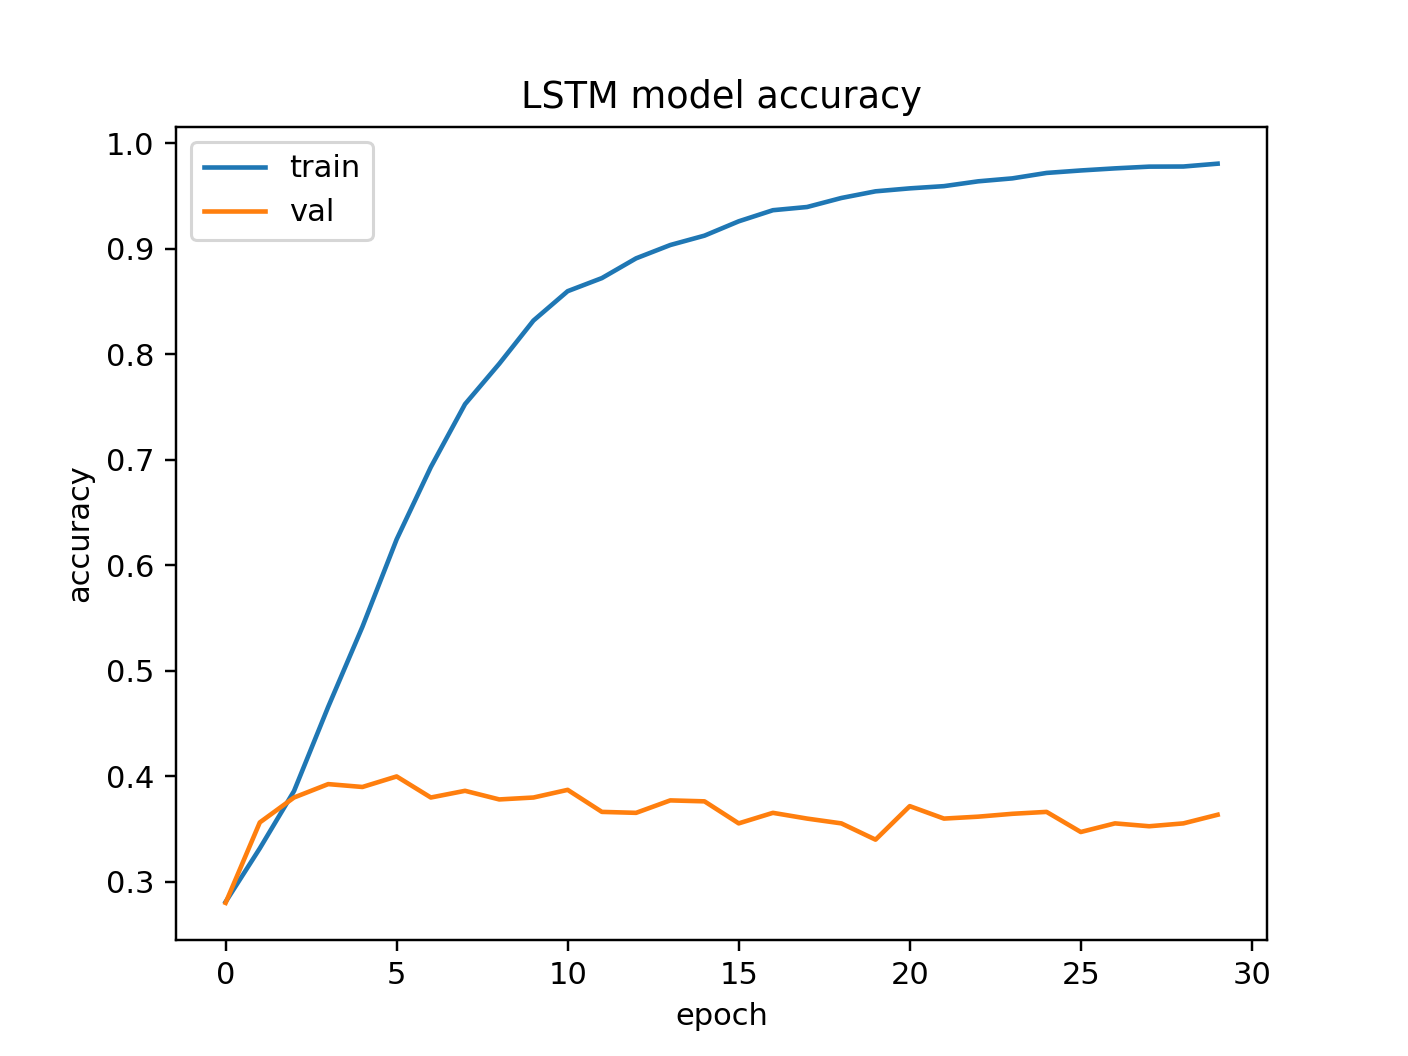

<IPython.core.display.Javascript object>


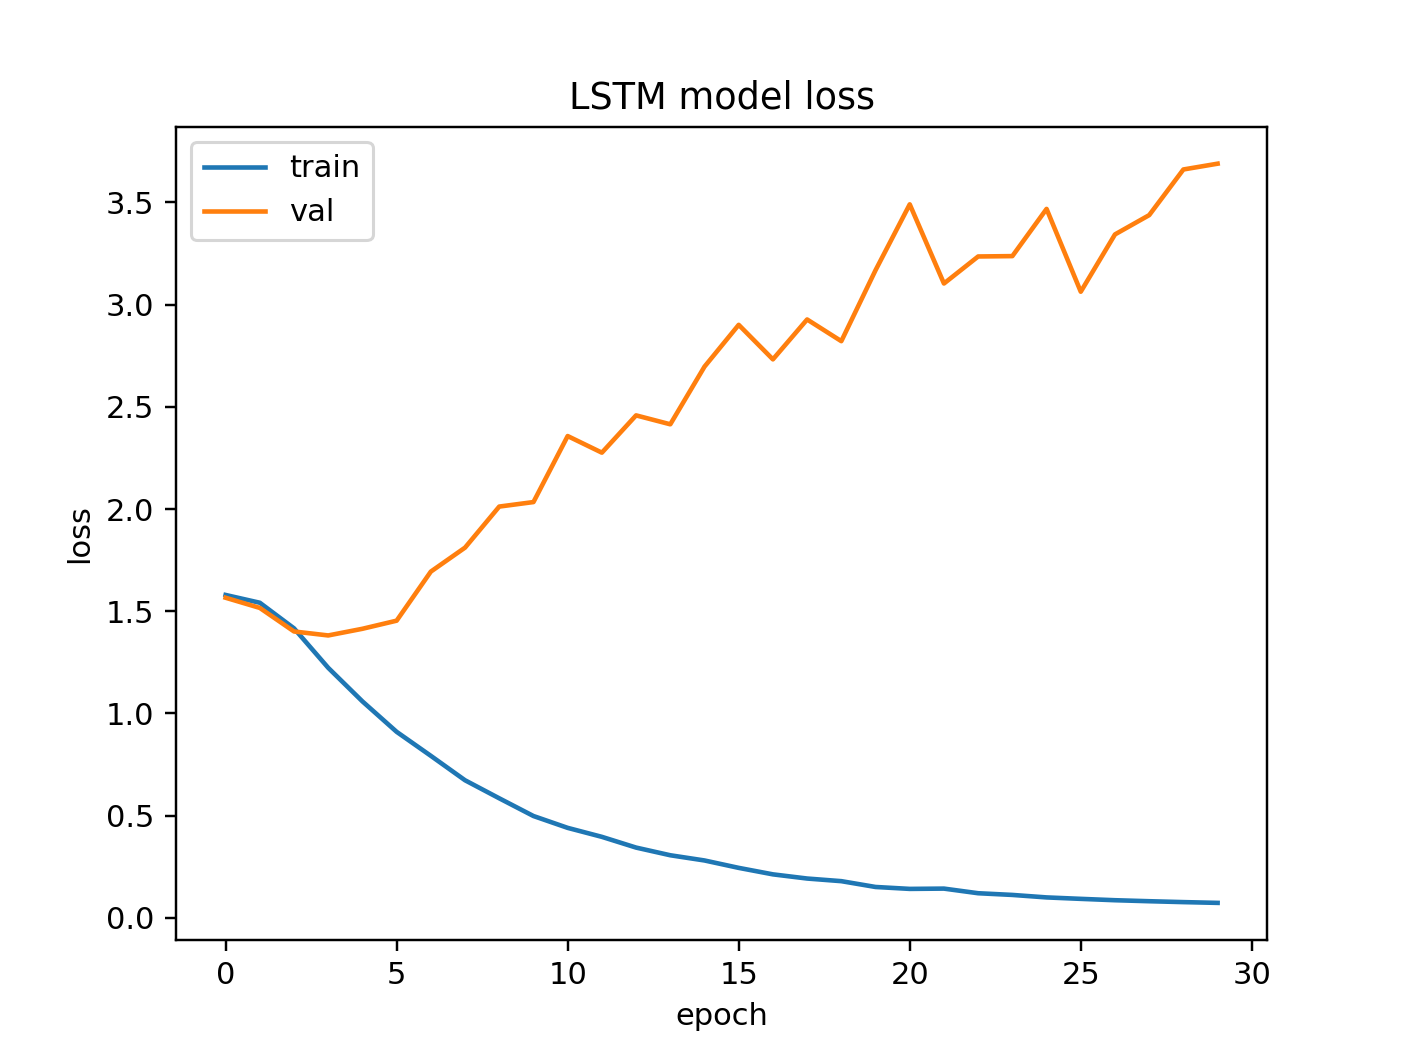

In [15]:
#Plot of the evolution of the training/validation accuracy

%matplotlib notebook

f = plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
f.show()

#Plot of the evolution of the training/validation loss

g = plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
g.show()

In [17]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

predictions_LSTM_model = model.predict(X_test)

f = open("logreg_lstm_y_test_sst.txt","w+")

for prediction_LSTM_model in predictions_LSTM_model:
    f.write(str(np.argmax(prediction_LSTM_model)) + "\n")
    
f.close()


## 4.3 - innovate !

In [17]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE


# We use the embeddings of the words and, therefore we need to associate each word of the input 
# sequence with its id in the embeddings dictionary


train_one_hot_sentences = []
dev_one_hot_sentences = []
test_one_hot_sentences = []

filters = ['!', '"', '#','$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>'  , '?' , '@'  '[', ']' , '\\', '^', '_', '\'', '{', '}', '|', '~', '\t', '\n'] 

for train_sentence in train_sentences:
    train_sentence_one_hot = []
    words_sentence = train_sentence.split()
    for word in words_sentence:
        word = word.lower()
        if word in word2vec.word2id and not word in filters:
            train_sentence_one_hot.append(word2vec.word2id[word])
        else:
            train_sentence_one_hot.append(50000)
    train_one_hot_sentences.append(train_sentence_one_hot)

for dev_sentence in dev_sentences:
    dev_sentence_one_hot = []
    words_sentence = dev_sentence.split()
    for word in words_sentence:
        word = word.lower()
        if word in word2vec.word2id and not word in filters:
            dev_sentence_one_hot.append(word2vec.word2id[word])
        else:
            dev_sentence_one_hot.append(50000)
    dev_one_hot_sentences.append(dev_sentence_one_hot)    
    
    
for test_sentence in test_sentences:
    test_sentence_one_hot = []
    words_sentence = test_sentence.split()
    for word in words_sentence:
        word = word.lower()
        if word in word2vec.word2id and not word in filters:
            test_sentence_one_hot.append(word2vec.word2id[word])
        else:
            test_sentence_one_hot.append(50000)
    test_one_hot_sentences.append(test_sentence_one_hot) 

    
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_one_hot_sentences)
X_dev = tf.keras.preprocessing.sequence.pad_sequences(dev_one_hot_sentences)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_one_hot_sentences)

n_classes  = 5

Y_train = tf.keras.utils.to_categorical(train_labels, n_classes)
Y_dev = tf.keras.utils.to_categorical(dev_labels, n_classes)

print("Train matrix after padding: ", X_train.shape)
print("Validation matrix after padding: ", X_dev.shape)
print("Test mastrix after padding: ", X_test.shape)

my_optimizer = tf.keras.optimizers.Adam(lr = 0.0001)


word2vec = Word2Vec(en_embeddings_path, vocab_size = 50000)


weight_matrix = np.vstack((word2vec.embeddings, np.zeros((1, word2vec.embeddings.shape[1]))))

print(weight_matrix.shape)


mbed_dim  = 300  # word embedding dimension
nhid       = 32  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary

model_2 = Sequential()
model_2.add(Embedding(vocab_size + 1, embed_dim, weights=[weight_matrix], trainable=False))
model_2.add(LSTM(nhid, dropout=0.3))
model_2.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  optimizer = tf.keras.optimizers.Adam(lr = 0.0001) # find the right optimizer
metrics_classif  =  ['accuracy']


model_2.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model_2.summary())

bs = 32
n_epochs = 200


history_2 = model_2.fit(X_train, Y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, Y_dev), shuffle=True)

#Wtite the predictions to the file

predictions_LSTM_pret_model = model_2.predict(X_test)

f = open("LSTM_pretrainedEmbeddings_y_test_sst.txt","w+")

for prediction_LSTM_pret_model in predictions_LSTM_pret_model:
    f.write(str(np.argmax(prediction_LSTM_pret_model)) + "\n")
    
f.close()


Train matrix after padding:  (8544, 52)
Validation matrix after padding:  (1101, 49)
Test mastrix after padding:  (2210, 56)
Loaded 50000 pretrained word vectors
(50001, 300)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         15000300  
_________________________________________________________________
lstm (LSTM)                  (None, 32)                42624     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 15,043,089
Trainable params: 42,789
Non-trainable params: 15,000,300
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
8544/8544 [======================

Epoch 109/200
8544/8544 [==============================] - 14s 2ms/sample - loss: 1.2548 - acc: 0.4566 - val_loss: 1.2961 - val_acc: 0.4214
Epoch 110/200
8544/8544 [==============================] - 14s 2ms/sample - loss: 1.2604 - acc: 0.4526 - val_loss: 1.2950 - val_acc: 0.4187
Epoch 111/200
8544/8544 [==============================] - 14s 2ms/sample - loss: 1.2530 - acc: 0.4533 - val_loss: 1.2972 - val_acc: 0.4242
Epoch 112/200
8544/8544 [==============================] - 14s 2ms/sample - loss: 1.2509 - acc: 0.4574 - val_loss: 1.2955 - val_acc: 0.4160
Epoch 113/200
8544/8544 [==============================] - 14s 2ms/sample - loss: 1.2532 - acc: 0.4466 - val_loss: 1.3011 - val_acc: 0.4151
Epoch 114/200
8544/8544 [==============================] - 14s 2ms/sample - loss: 1.2504 - acc: 0.4580 - val_loss: 1.2927 - val_acc: 0.4169
Epoch 115/200
8544/8544 [==============================] - 14s 2ms/sample - loss: 1.2499 - acc: 0.4577 - val_loss: 1.2908 - val_acc: 0.4223
Epoch 116/200
8544/8